训练数据大小：[[[ 8.8200e-02]
  [ 5.1900e-02]
  [ 1.1260e-01]
  [ 2.0740e-01]
  [ 2.2040e-01]
  [ 1.0970e-01]
  [ 2.3750e-01]
  [ 2.1360e-01]
  [ 2.4700e-01]
  [ 3.0340e-01]
  [ 3.2050e-01]
  [ 4.1620e-01]
  [ 4.1130e-01]
  [ 4.0880e-01]
  [ 4.5400e-01]
  [ 4.7710e-01]
  [ 5.6330e-01]
  [ 5.0610e-01]
  [ 5.5920e-01]
  [ 5.2750e-01]
  [ 4.6870e-01]]

 [[ 6.5450e-01]
  [ 6.9000e-01]
  [ 6.3400e-01]
  [ 8.0820e-01]
  [ 6.4500e-01]
  [ 7.4220e-01]
  [ 7.5210e-01]
  [ 8.5890e-01]
  [ 8.7580e-01]
  [ 8.2930e-01]
  [ 8.5890e-01]
  [ 8.1330e-01]
  [ 7.7540e-01]
  [ 8.7300e-01]
  [ 9.1330e-01]
  [ 9.8120e-01]
  [ 9.9310e-01]
  [ 9.2610e-01]
  [ 9.4180e-01]
  [ 9.1500e-01]
  [ 9.0610e-01]]

 [[ 9.0040e-01]
  [ 1.0910e+00]
  [ 9.7470e-01]
  [ 9.8400e-01]
  [ 9.4810e-01]
  [ 1.0534e+00]
  [ 9.3660e-01]
  [ 1.0085e+00]
  [ 9.7520e-01]
  [ 1.0392e+00]
  [ 9.9320e-01]
  [ 9.5760e-01]
  [ 1.0121e+00]
  [ 1.0309e+00]
  [ 1.0077e+00]
  [ 1.0135e+00]
  [ 9.5960e-01]
  [ 9.6530e-01]
  [ 9.4090e-01]
  [ 9.4670e-0

100%|██████████| 150/150 [00:13<00:00, 10.99it/s, Epoch=149, LSTM loss=0.0035, LSTM test loss=0.6108]


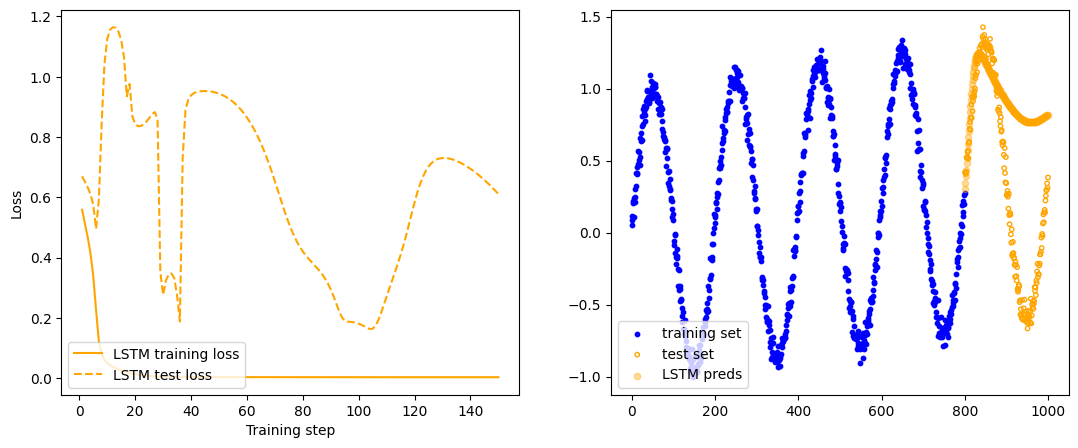

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
import torch.nn as nn

# 导入数据集
data = np.loadtxt('sindata_1000.csv', delimiter=',') #数据集的大小是1000行一列
num_data = len(data)
split = int(0.8 * num_data)
# 分割数据集
train_data = np.array(data[:split])
test_data = np.array(data[split:])
# 输入序列长度
seq_len = 20
# 处理训练数据，把切分序列后多余的部分去掉
train_num = len(train_data) // (seq_len + 1) * (seq_len + 1) 
train_data = np.array(train_data[:train_num]).reshape(-1, seq_len + 1, 1)
print(f'训练数据大小：{len(train_data)}')
print(f'数据集大小：{num_data}')
np.random.seed(0)
torch.manual_seed(0)

x_train = train_data[:, :seq_len] # 形状为(num_data, seq_len, input_size)
y_train = train_data[:, 1: seq_len + 1]
print(f'训练序列数：{len(x_train)}')

# 转为PyTorch张量
x_train = torch.from_numpy(x_train).to(torch.float32)
y_train = torch.from_numpy(y_train).to(torch.float32)
x_test = torch.from_numpy(test_data[:-1]).to(torch.float32)
y_test = torch.from_numpy(test_data[1:]).to(torch.float32)

class LSTM(nn.Module): #继承nn.Module，实现LSTM网络
    def __init__(self, input_size, output_size, hidden_size):
        super().__init__()
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size) # 调用PyTorch的LSTM
        self.linear = nn.Linear(hidden_size, output_size)
        self.hidden_size = hidden_size
        
    def forward(self, x, hidden):
        out, hidden = self.lstm(torch.transpose(x, 0, 1), hidden) 
        out = self.linear(out.view(-1, self.hidden_size)) 
        return out, hidden
    
input_size = 1 # 输入维度
output_size = 1 # 输出维度
hidden_size = 16 # 中间变量维度
learning_rate = 5e-4

# 初始化LSTM网络和优化器
lstm = LSTM(input_size, output_size, hidden_size)
lstm_optim = torch.optim.Adam(lstm.parameters(), lr=learning_rate)

# LSTM测试函数
def test_lstm(lstm, x, hidden, pred_steps):
    pred = []
    inp = x.view(-1, input_size)
    for i in range(pred_steps):
        lstm_pred, hidden = lstm(inp, hidden)
        pred.append(lstm_pred.detach())
        inp = lstm_pred
    return torch.concat(pred).reshape(-1)

max_epoch = 150
criterion = nn.functional.mse_loss

lstm_losses = []
lstm_test_losses = []

with tqdm(range(max_epoch)) as pbar:
    for epoch in pbar:
        lstm_loss = 0.0
        # 初始化hidden
        lstm_hidden = (torch.zeros(1, 1, hidden_size), torch.zeros(1, 1, hidden_size))
        for X, y in zip(x_train, y_train):
            # LSTM训练
            lstm_hidden = (lstm_hidden[0].detach(), lstm_hidden[1].detach())
            lstm_pred, lstm_hidden = lstm(X[None, ...], lstm_hidden)
            lstm_train_loss = criterion(lstm_pred.view(y.shape), y)
            lstm_optim.zero_grad()
            lstm_train_loss.backward()
            lstm_optim.step()
            lstm_loss += lstm_train_loss.item()

        lstm_loss /= len(x_train)
        lstm_losses.append(lstm_loss)
        # 测试
        lstm_h, lstm_c = lstm_hidden
        lstm_h_test = lstm_h[:, -1, :].squeeze(1)  # [num_layers, hidden_size]
        lstm_c_test = lstm_c[:, -1, :].squeeze(1)  # [num_layers, hidden_size]
        lstm_pred = test_lstm(lstm, x_test[0], (lstm_h_test, lstm_c_test), len(y_test))
        lstm_test_loss = criterion(lstm_pred, y_test).item()
        lstm_test_losses.append(lstm_test_loss)
        pbar.set_postfix({
            'Epoch': epoch,
            'LSTM loss': f'{lstm_loss:.4f}',
            'LSTM test loss': f'{lstm_test_loss:.4f}'
        })

# 最终测试结果
lstm_h, lstm_c = lstm_hidden
lstm_h_test = lstm_h[:, -1, :].squeeze(1)  # [num_layers, hidden_size]
lstm_c_test = lstm_c[:, -1, :].squeeze(1)  # [num_layers, hidden_size]
lstm_preds = test_lstm(lstm, x_test[0], (lstm_h_test, lstm_c_test), len(y_test)).numpy()

plt.figure(figsize=(13, 5))
plt.subplot(121)
x_plot = np.arange(len(lstm_losses)) + 1
plt.plot(x_plot, lstm_losses, color='orange', label='LSTM training loss')
plt.plot(x_plot, lstm_test_losses, color='orange', ls='--', label='LSTM test loss')
plt.xlabel('Training step')
plt.ylabel('Loss')
plt.legend(loc='lower left')

plt.subplot(122)
plt.scatter(np.arange(split), data[:split], color='blue', s=10, label='training set')
plt.scatter(np.arange(split, num_data), data[split:], color='none', edgecolor='orange', s=10, label='test set')
plt.scatter(np.arange(split, num_data - 1), lstm_preds, color='orange', marker='o', alpha=0.4, s=20, label='LSTM preds')
plt.legend(loc='lower left')
plt.savefig('output_LSTM.png')
plt.savefig('output_LSTM.pdf')
plt.show()